In [1]:
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        }
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE"},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1}

        
}

pipe = RubixPipeline(config)

data= pipe.run()

2024-05-09 20:05:37,226 - rubix - INFO - Getting rubix data...
2024-05-09 20:05:37,227 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2024-05-09 20:05:39,277 - rubix - INFO - Data loaded with 484076 particles.
2024-05-09 20:05:39,277 - rubix - INFO - Setting up the pipeline...
2024-05-09 20:05:39,278 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {'type': 'face-on'}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'split_data': {'name': 'split_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}}}
/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/factory.py:20: UserWarning: No telescope config provided, using default stored in /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubi

rotating galaxy:  face-on


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[484076].
The error occurred because of argument 'x' of jnp.bincount. To avoid this error, pass a static `length` argument.
The error occurred while tracing the function expr at /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/pipeline/linear_pipeline.py:150 for jit. This concrete value was not available in Python because it depends on the value of the argument input['coords'].

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [3]:
data

{'age': Array([10.263583,  5.437086,  9.445876, ...,  6.081484,  6.046955,
         7.828335], dtype=float32),
 'coords': Array([[ 2.9327204e-03, -1.1268407e-01, -5.1659189e-02],
        [-2.6811140e-02, -1.1069263e-01,  1.0449078e-03],
        [ 5.6707028e-02, -7.6940567e-03, -2.4860032e-02],
        ...,
        [-1.3508391e+01,  1.8576612e+01,  2.2140955e+01],
        [ 9.8341805e+01,  9.1229645e+01,  7.2014679e+01],
        [ 1.0762643e+02,  6.8130775e+01,  7.4728523e+01]], dtype=float32),
 'mass': Array([ 97385.62 , 142424.39 , 127747.555, ...,  69271.21 , 106484.266,
         84167.805], dtype=float32),
 'metallicity': Array([0.02458057, 0.07107806, 0.05189282, ..., 0.00559624, 0.0086777 ,
        0.00501246], dtype=float32),
 'pixel_assignment': Array([300, 300, 300, ..., 552, 575, 575], dtype=int32),
 'spatial_bin_edges': Array([-4.7619    , -4.380948  , -3.9999962 , -3.6190443 , -3.2380924 ,
        -2.8571405 , -2.4761887 , -2.0952368 , -1.7142849 , -1.333333  ,
        -0.95

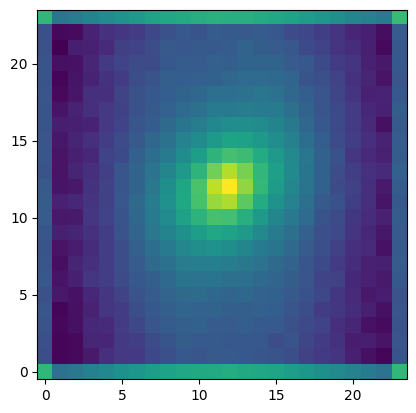

In [4]:
# NBVAL_SKIP
import numpy as np
import matplotlib.pyplot as plt

spatial_bin_edges = data["spatial_bin_edges"]
pixel_assignments = data["pixel_assignment"]
image = np.zeros((len(spatial_bin_edges) - 1, len(spatial_bin_edges) - 1))

# Count the number of particles in each pixel
for i in range(len(spatial_bin_edges) - 1):
    for j in range(len(spatial_bin_edges) - 1):
        image[i, j] = np.sum(pixel_assignments == (i + (len(spatial_bin_edges) - 1) * j))
        

image = np.log10(image + 1) 
plt.imshow(image, cmap='viridis', origin='lower')

In [6]:
import jax.numpy as jnp

def restructure_data(masses, indices, num_pixels=25**2):
    # Calculate the number of particles per pixel
    particle_count = jnp.bincount(indices, minlength=num_pixels)

    # Determine the maximum number of particles in any pixel
    max_particles = particle_count.max()

    # Create an array filled with zeros where rows correspond to pixels
    # and columns correspond to particles in that pixel
    structured_array = jnp.zeros((num_pixels, max_particles))

    # Fill the structured array with masses
    for i in range(num_pixels):
        # Find the particles in the current pixel
        mask = indices == i
        # Place these in the structured array
        structured_array = structured_array.at[i, :mask.sum()].set(masses[mask])

    return structured_array

result_long =restructure_data(data["mass"], data["pixel_assignment"], num_pixels=25**2)

In [16]:
import jax.numpy as jnp
from jax.ops import segment_sum

def restructure_data(masses, indices, num_pixels=25**2):
    # Calculate the number of particles per pixel
    particle_count = jnp.bincount(indices, minlength=num_pixels)

    # Determine the maximum number of particles in any pixel
    max_particles = particle_count.max()

    # Create an array of indices for each particle's position within its pixel
    # `cumsum` on `particle_count` shifted right gives us the starting index of each pixel's data in a flattened array
    positions = jnp.cumsum(jnp.bincount(indices, minlength=num_pixels), axis=0)
    positions = jnp.roll(positions, shift=1)
    positions = positions.at[0].set(0)
    pixel_indices = jnp.repeat(jnp.arange(num_pixels), particle_count)

    # Use `segment_sum` to map masses to the correct pixels
    structured_array = segment_sum(masses, indices, num_segments=num_pixels)

    return structured_array, particle_count, max_particles


result = restructure_data(data["mass"], data["pixel_assignment"], num_pixels=25**2)

In [87]:
import jax.numpy as jnp

def restructure_data_fixed(masses, indices, num_pixels=25**2):
    # Calculate the number of particles per pixel
    particle_count = jnp.bincount(indices, minlength=num_pixels)

    # Determine the maximum number of particles in any pixel
    max_particles = particle_count.max()

    # Initialize the structured array
    structured_array = jnp.zeros((num_pixels, max_particles), dtype=masses.dtype)

    # Calculate the positions within each pixel for every mass
    indices_sort = jnp.argsort(indices)
    sorted_indices = indices[indices_sort]
    sorted_masses = masses[indices_sort]

    # Calculate particle index within each pixel
    position_within_pixel = jnp.cumsum(sorted_indices == jnp.roll(sorted_indices, 1)) - 1

    # Place masses in the structured array
    structured_array = structured_array.at[sorted_indices, position_within_pixel].add(sorted_masses)

    return structured_array







result_short = restructure_data_fixed(data["mass"], data["pixel_assignment"], num_pixels=25**2)




In [135]:
def restructure_data_fixed(masses, indices, num_pixels=25**2):
    # Calculate the number of particles per pixel
    particle_count = jnp.bincount(indices, minlength=num_pixels)

    # Determine the maximum number of particles in any pixel
    max_particles = particle_count.max()

    # Initialize the structured array
    structured_array = jnp.zeros((num_pixels, max_particles), dtype=masses.dtype)

    # Helper array to keep track of the next free position in each pixel
    next_position = jnp.zeros(num_pixels, dtype=jnp.int32)

    # Fill the structured array
    for idx, mass in zip(indices, masses):
        position = next_position[idx]
        structured_array = structured_array.at[idx, position].set(mass)
        next_position = next_position.at[idx].add(1)

    return structured_array

result_short = restructure_data_fixed(data["mass"], data["pixel_assignment"], num_pixels=25**2)



KeyboardInterrupt: 

In [138]:
from jax import lax
def restructure_data_fixed(masses, indices, num_pixels=25**2):
    # Calculate the number of particles per pixel
    particle_count = jnp.bincount(indices, minlength=num_pixels)

    # Determine the maximum number of particles in any pixel
    max_particles = particle_count.max()

    # Initialize the structured array and next free position tracker
    structured_array = jnp.zeros((num_pixels, max_particles), dtype=masses.dtype)
    next_position = jnp.zeros(num_pixels, dtype=jnp.int32)

    # Prepare data for scan
    mass_index_pairs = jnp.stack([masses, indices], axis=1)

    # Define the function to be scanned, updating structured_array and next_position
    def populate_structured_array(carry, x):
        array, pos = carry
        mass, idx = int(x[0]), int(x[1])
        position = pos[idx]
        # Update the structured array and the position tracker
        updated_array = array.at[idx, position].set(mass)
        updated_pos = pos.at[idx].add(1)
        return (updated_array, updated_pos), None

    # Perform the scan operation
    (structured_array, _), _ = lax.scan(populate_structured_array, (structured_array, next_position), mass_index_pairs)

    return structured_array


results_lax = restructure_data_fixed(data["mass"], data["pixel_assignment"], num_pixels=25**2)


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape float32[].
The problem arose with the `int` function. If trying to convert the data type of a value, try using `x.astype(int)` or `jnp.array(x, int)` instead.
The error occurred while tracing the function populate_structured_array at /tmp/ipykernel_126923/3961180506.py:17 for scan. This concrete value was not available in Python because it depends on the value of the argument x.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [134]:
indices = data["pixel_assignment"]
masses = data["mass"]
num_pixels = 25**2

# Calculate the number of particles per pixel
particle_count = jnp.bincount(indices, minlength=num_pixels)

# Determine the maximum number of particles in any pixel
max_particles = particle_count.max()



# Initialize the structured array
structured_array = jnp.zeros((num_pixels, max_particles), dtype=masses.dtype)

# Calculate the positions within each pixel for every mass
indices_sort = jnp.argsort(indices)
sorted_indices = indices[indices_sort]
sorted_masses = masses[indices_sort]
new_pixel_starts = jnp.concatenate((jnp.array([True]), sorted_indices[1:] != sorted_indices[:-1]))

# Calculate position_within_pixel by cumulatively summing up where new_pixel_starts is False
position_within_pixel = jnp.cumsum(new_pixel_starts == False)

print(position_within_pixel.max())
print(max_particles)
# Ensure no index exceeds its bounds
assert position_within_pixel.max() < max_particles, "Particle index exceeds allocated space."
assert sorted_indices.max() < num_pixels, "Pixel index out of bounds."

# Calculate particle index within each pixel
#position_within_pixel = jnp.cumsum(sorted_indices == jnp.roll(sorted_indices, 1)) - 1

# Place masses in the structured array
structured_array = structured_array.at[sorted_indices, position_within_pixel].add(sorted_masses)


483500
47555


AssertionError: Particle index exceeds allocated space.

In [131]:
new_pixel_starts

Array([ True, False, False, ..., False, False, False], dtype=bool)

In [130]:
structured_array[505]

Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [83]:

def restructure_data_fixed(masses, indices, num_pixels=25**2):
    # Calculate the number of particles per pixel
    particle_count = jnp.bincount(indices, minlength=num_pixels)

    # Determine the maximum number of particles in any pixel
    max_particles = particle_count.max()

    # Initialize the structured array
    structured_array = jnp.zeros((num_pixels, max_particles), dtype=masses.dtype)

    # Sort indices and masses based on indices
    indices_sort = jnp.argsort(indices)
    sorted_indices = indices[indices_sort]
    sorted_masses = masses[indices_sort]

    # Detect boundaries where the pixel index changes
    changes = jnp.concatenate([jnp.array([True]), sorted_indices[1:] != sorted_indices[:-1]])

    # Calculate the position within each pixel
    positions_within_pixel = jnp.cumsum(changes) - jnp.cumsum(jnp.concatenate([jnp.array([0]), changes[:-1]]))

    # Place masses in the structured array
    structured_array = structured_array.at[sorted_indices, positions_within_pixel - 1].set(sorted_masses)

    return structured_array

result_short = restructure_data_fixed(data["mass"], data["pixel_assignment"], num_pixels=25**2)

In [85]:
result_short[4]

Array([72485.14 ,     0.   ,     0.   , ...,     0.   ,     0.   ,
       83518.586], dtype=float32)

In [88]:
long = result_long[0].sort()
short = result_short[0].sort()

jnp.allclose(long, short)

for index in range(len(result_long)):
    is_clos = jnp.allclose(result_long[index].sort(), result_short[index].sort())
    if not is_clos:
        print(index)


185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434


In [72]:
result_long[194].sort()

Array([     0.  ,      0.  ,      0.  , ..., 147212.61, 147567.89,
       156014.1 ], dtype=float32)

In [74]:
result_short[182].sort()

Array([       0.,        0.,        0., ...,        0.,        0.,
       43893692.], dtype=float32)